In [1]:
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [2]:
DATASET_PATH = '../dataset'
OUTPUT_PATH = './output'
MODELS_PATH = './output_models'

In [3]:
image_size = 64
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

In [4]:
dataset = ImageFolder(root=DATASET_PATH, transform=transform)

dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4)

In [5]:
if os.path.exists(OUTPUT_PATH):
    shutil.rmtree(OUTPUT_PATH)
os.makedirs(OUTPUT_PATH,exist_ok=True)

In [6]:
if os.path.exists(MODELS_PATH):
    shutil.rmtree(MODELS_PATH)
os.makedirs(MODELS_PATH,exist_ok=True)

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_size, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_size, ngf * 8, 4, 1, 0, bias=False),  # 1x1 -> 4x4
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),  # 4x4 -> 8x8
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),  # 8x8 -> 16x16
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),  # 16x16 -> 32x32
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),  # 32x32 -> 64x64
            nn.Tanh()  # Output: 64x64xnc
        )

    def forward(self, input):
        return self.main(input)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, ndf, nc):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),  # 64x64 -> 32x32
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),  # 32x32 -> 16x16
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),  # 16x16 -> 8x8
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),  # 8x8 -> 4x4
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),  # 4x4 -> 1x1
            nn.Flatten(),
            nn.Sigmoid()  # Output: Single scalar
        )

    def forward(self, input):
        return self.main(input)

In [9]:
latent_size = 128
ngf = 64
ndf = 64
nc = 3

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# Create the generator and discriminator
netG = Generator(latent_size, ngf, nc).to(device)
netD = Discriminator(ndf, nc).to(device)

# Print the model architectures
print(netG)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [12]:
epochs = 150
batch_size = 128

In [13]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, latent_size, 1, 1, device=device)

optimizerD = optim.Adam(netD.parameters(), lr=3e-4, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=3e-4, betas=(0.5, 0.999))


In [14]:
def train_discriminator(netD, netG, criterion, optimizerD, real_images, batch_size, latent_size, device):
    netD.zero_grad()

    # Train with real images
    real_labels = torch.ones(batch_size, 1, device=device)
    real_output = netD(real_images)
    real_loss = criterion(real_output, real_labels)
    real_loss.backward()
    real_score = real_output.mean().item()

    # Generate fake images and train
    noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = netG(noise)
    fake_labels = torch.zeros(batch_size, 1, device=device)
    fake_output = netD(fake_images.detach())
    fake_loss = criterion(fake_output, fake_labels)
    fake_loss.backward()
    fake_score = fake_output.mean().item()

    # Update Discriminator
    optimizerD.step()

    # Combine losses
    lossD = real_loss + fake_loss

    return lossD.item(), real_score, fake_score

In [15]:
def train_generator(netD, netG, criterion, optimizerG, batch_size, latent_size, device):
    netG.zero_grad()
    
    noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = netG(noise)
    labels = torch.ones(batch_size, 1, device=device)
    output = netD(fake_images)
    lossG = criterion(output, labels)
    lossG.backward()

    # Update Generator
    optimizerG.step()

    return lossG.item()

In [16]:
def train_gan(epochs, dataloader, netD, netG, criterion, optimizerD, optimizerG, latent_size, device):
    fixed_noise = torch.randn(64, latent_size, 1, 1, device=device)
    generator_losses = []
    discriminator_losses = []

    for epoch in range(epochs):
        for real_images, _ in dataloader:
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # Train Discriminator
            lossD, real_score, fake_score = train_discriminator(netD, netG, criterion, optimizerD, real_images, batch_size, latent_size, device)

            # Train Generator
            lossG = train_generator(netD, netG, criterion, optimizerG, batch_size, latent_size, device)

        generator_losses.append(lossG)
        discriminator_losses.append(lossD)
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss_D: {lossD:.4f}, Loss_G: {lossG:.4f}, Real_Score: {real_score:.4f}, Fake_Score: {fake_score:.4f}')
        
        # Save generated images
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
            vutils.save_image(fake, f'output/generated_{epoch+1}.png', normalize=True)
    
    return generator_losses, discriminator_losses

In [17]:
generator_losses, discriminator_losses = train_gan(epochs, dataloader, netD, netG, criterion, optimizerD, optimizerG, latent_size, device)

Epoch [1/150], Loss_D: 0.6075, Loss_G: 3.4921, Real_Score: 0.7660, Fake_Score: 0.2810
Epoch [2/150], Loss_D: 0.4525, Loss_G: 3.1574, Real_Score: 0.9380, Fake_Score: 0.2930
Epoch [3/150], Loss_D: 0.4384, Loss_G: 5.6720, Real_Score: 0.7753, Fake_Score: 0.1608
Epoch [4/150], Loss_D: 0.7144, Loss_G: 3.7276, Real_Score: 0.6808, Fake_Score: 0.2268
Epoch [5/150], Loss_D: 0.7118, Loss_G: 3.1384, Real_Score: 0.5058, Fake_Score: 0.0240
Epoch [6/150], Loss_D: 1.0525, Loss_G: 9.9945, Real_Score: 0.9611, Fake_Score: 0.5932
Epoch [7/150], Loss_D: 3.9866, Loss_G: 6.5417, Real_Score: 0.0255, Fake_Score: 0.0004
Epoch [8/150], Loss_D: 1.1369, Loss_G: 8.4657, Real_Score: 0.9448, Fake_Score: 0.6085
Epoch [9/150], Loss_D: 0.1915, Loss_G: 3.7347, Real_Score: 0.8595, Fake_Score: 0.0339
Epoch [10/150], Loss_D: 0.5483, Loss_G: 4.5827, Real_Score: 0.9919, Fake_Score: 0.3935
Epoch [11/150], Loss_D: 0.2356, Loss_G: 1.3336, Real_Score: 0.8840, Fake_Score: 0.0937
Epoch [12/150], Loss_D: 0.2931, Loss_G: 3.5614, Real

In [18]:
torch.save(netG.state_dict(), f'{MODELS_PATH}/generator.pth')
torch.save(netD.state_dict(), f'{MODELS_PATH}/discriminator.pth')

In [19]:
netG.load_state_dict(torch.load(f'{MODELS_PATH}/generator.pth'))
netD.load_state_dict(torch.load(f'{MODELS_PATH}/discriminator.pth'))
netG.eval()
netD.eval()

/tmp/ipykernel_45928/609074569.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(f'{MODELS_PATH}/generator.pth'))
/tmp/ipykernel_45928/6090

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kernel_size=(

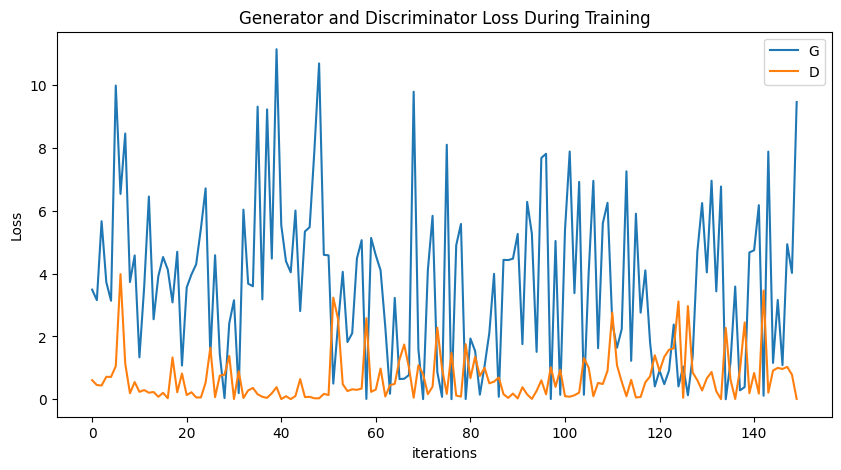

In [20]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_losses, label="G")
plt.plot(discriminator_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [21]:
import cv2

vid_fname = 'gan_training.avi'

files = [os.path.join(OUTPUT_PATH, f) for f in os.listdir(OUTPUT_PATH) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'avi / AVI (Audio Video Interleaved)'
OpenCV: FFMPEG: fallback to use tag 0x34504d46/'FMP4'
